![alt text](<https://www.et-gw.eu/images/et-new-logo.png>)

# XIII ET Symposium: Hackathon Session


### GWFish Tutorial: a brief guide for your first steps in using GWFish

## Settings for Google Colab

In [ ]:
#! pip install -q git+https://github.com/janosch314/GWFish

In [ ]:
#! pip install -q lalsuite

In [ ]:
#! pip install -q corner

**Note 1**: in Google Colab remember to **restart the kernel runtime** after installation

**Note 2**: GWFish uses LALSimulation, so the package needs to be installed separately from GWFish

## Import packages

In [1]:
import GWFish.modules as gw

from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import corner
import numpy as np
import pandas as pd
import json
import os
from astropy.cosmology import Planck18

GWFish_path = 'GWFish/'

# Single Event Analysis: GW170817-like

## Initialize GWFish

Here we are using the **GW180817** BNS event as it would have been seen with a triangular shape ET located in Sardinia.

* We need to specify the population type (BNS or BBH), then the detectors and the network
* The choice of the waveform approximant can be done from all the availbale waveforms from **LALSimulation**
* All the detectors characteristics are specified in the **detectors.yaml** file
* For a more realistic analysis we can include the **duty cycle** of the detectors using `duty_cycle = True`

In [2]:
population = 'BNS' # or 'BBH'
detectors = ['ET']
networks = '[[0]]'

detectors_ids = detectors
networks_ids = json.loads(networks)
ConfigDet = os.path.join(GWFish_path,'detectors.yaml')

calculate_errors = True
duty_cycle = False

waveform_model = 'IMRPhenomD_NRTidalv2'
waveform_class = gw.waveforms.LALFD_Waveform

### Injections

We can analyze single events or entire populations (see below). Here consider the GW170817 event. 

The parameters need to passed as a **DataFrame** with the following nomenclature:
- `mass_1`: primary mass of the binary in Msol (in source frame)
- `mass_2`: secondary mass of the binary in Msol (in source frame)
- `redshift`: the redshift of the merger
- `luminosity_distance`:  the luminosity distance of the merger in Mpc
- `theta_jn`: the inclination angle between the line of observation and the perpendicular to the binary plane in rad
- `dec`: declination angle in rad
- `ra`: right ascension in rad
- `psi`: the polarization angle in rad
- `phase`: the initial phase of the merger in rad
- `geocent_time`: merger time as GPS time
- `a_1`: dimensionless spin parameter of primary component
- `a_2`: dimensionless spin parameter of secondary component
- `lambda_1`: tidal polarizabilty of primary component
- `lambda_2`: tidal polarizabilty of secondary component

In [3]:
z = np.array([0.00980])

parameters = {
    'mass_1': np.array([1.4957673]), 
    'mass_2': np.array([1.24276395]), 
    'redshift': z,
    'luminosity_distance': Planck18.luminosity_distance(z).value,
    'theta_jn': np.array([2.545065595974997]),
    'ra': np.array([3.4461599999999994]), # phi in gwfast
    'dec': np.array([-0.4080839999999999]), # pi/2 - theta
    'psi': np.array([0.]),
    'phase': np.array([0.]),
    'geocent_time': np.array([1187008882.4]),
    'a_1':np.array([0.005136138323169717]), 
    'a_2':np.array([0.003235146993487445]), 
    'lambda_1':np.array([368.17802383555687]), 
    'lambda_2':np.array([586.5487031450857])}
parameters = pd.DataFrame(parameters)
parameters

,mass_1,mass_2,redshift,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2,lambda_1,lambda_2
0,1.495767,1.242764,0.0098,43.747554,2.545066,3.44616,-0.408084,0.0,0.0,1.187009e+09,0.005136,0.003235,368.178024,586.548703


### Initialize Network

If we want to compute the Fisher matrix we need to specify the parameters in the detector network settigs. Moreover, we need to specify what is the minimum network SNR for Fisher analysis (the fiducial value is set to SNR = 8.)

In [4]:
threshold_SNR = np.array([0., 8.])
fisher_parameters = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'lambda_1', 'lambda_2']
network = gw.detection.Network(detectors_ids, detection_SNR=threshold_SNR, parameters=parameters,
                               fisher_parameters=fisher_parameters, config=ConfigDet)


### Calculate SNR

In [5]:
for k in tqdm(np.arange(len(parameters))):
    parameter_values = parameters.iloc[k]

    networkSNR_sq = 0
    for d in np.arange(len(network.detectors)):
        data_params = {
            'frequencyvector': network.detectors[d].frequencyvector,
            'f_ref': 50.
        }
        waveform_obj = waveform_class(waveform_model, parameter_values, data_params)
        wave = waveform_obj()
        t_of_f = waveform_obj.t_of_f

        signal = gw.detection.projection(parameter_values, network.detectors[d], wave, t_of_f)

        SNRs = gw.detection.SNR(network.detectors[d], signal, duty_cycle=duty_cycle)
        networkSNR_sq += np.sum(SNRs ** 2)
        network.detectors[d].SNR[k] = np.sqrt(np.sum(SNRs ** 2))

        if calculate_errors:
            network.detectors[d].fisher_matrix[k, :, :] = \
                gw.fishermatrix.FisherMatrix(waveform_model, parameter_values, fisher_parameters, network.detectors[d], waveform_class=waveform_class).fm

    network.SNR[k] = np.sqrt(networkSNR_sq)

gw.detection.analyzeDetections(network, parameters, population, networks_ids)

if calculate_errors:
    gw.fishermatrix.analyzeFisherErrors(network, parameters, fisher_parameters, population, networks_ids)


print('The network SNR of the event is ', network.SNR[0])

100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]

Network: ET
Detected signals with SNR>8.000: 1.000 (1 out of 1); z<0.010
SNR: 636.216 (min) , 636.216 (max) 
The network SNR of the event is  636.2157090152681


### Plot Signal

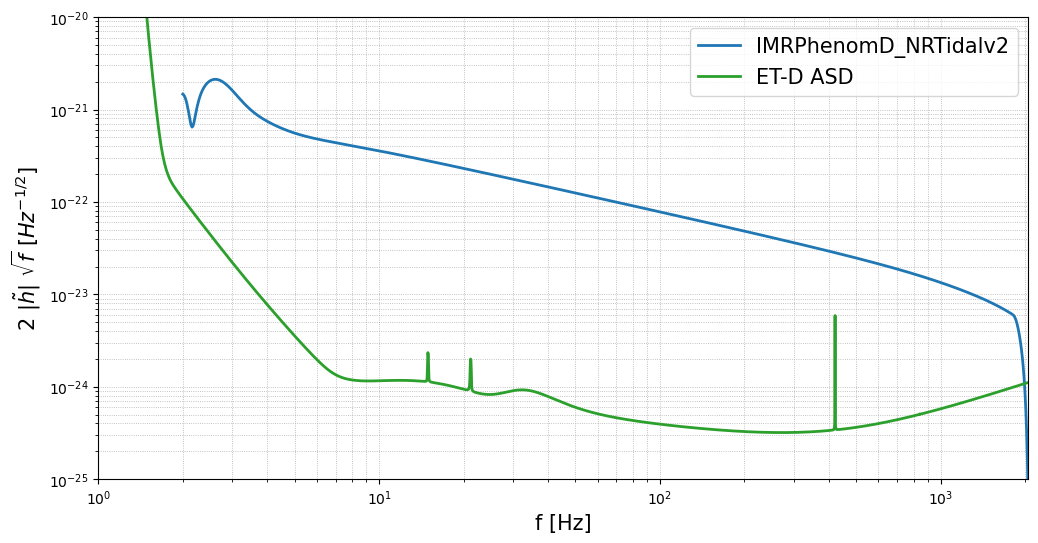

In [6]:
h_plus, h_cross = signal[:, 0], signal[:, 1]
ampl = np.sqrt(np.abs(h_plus)**2. + np.abs(h_cross)**2.)

psd_et_D = np.loadtxt(os.path.join(GWFish_path,'detector_psd/ET_psd.txt'), usecols=[0,1])
frequencyvector = network.detectors[d].frequencyvector[:, 0]

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(frequencyvector, 2.*np.sqrt(frequencyvector)*ampl, 
        linewidth=2., label='%s' %(waveform_model))
ax.plot(psd_et_D[:,0],np.sqrt(psd_et_D[:,1]), linewidth=2.0, color='C2', label='ET-D ASD')

ax.set_xlim(1.,frequencyvector[-1])
ax.set_ylim(1e-25, 1e-20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel(r'$2 \ |\tilde{h}| \ \sqrt{f}\ [Hz^{-1/2}]$', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')
ax.legend(loc='upper right', fontsize=15, ncol=1, fancybox=True)

plt.show()

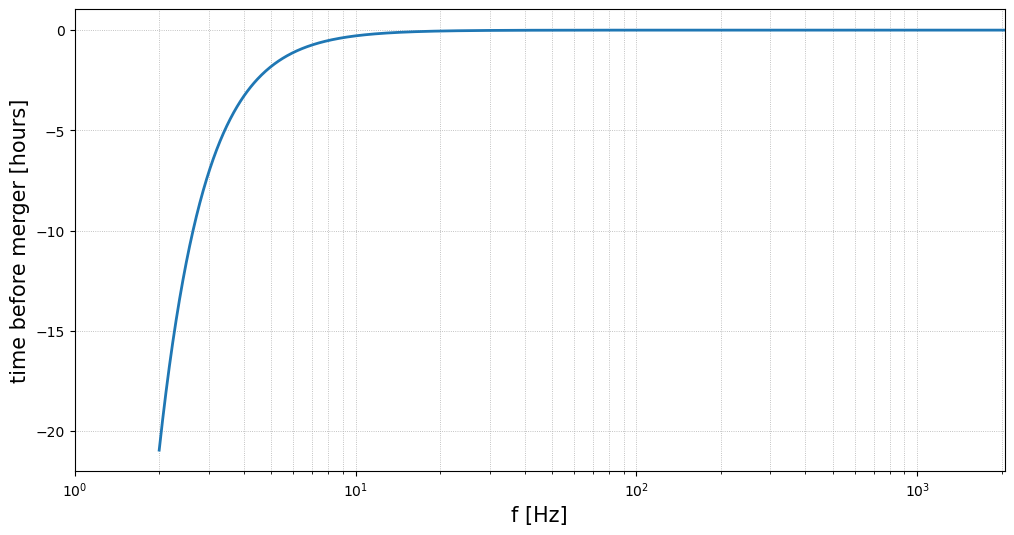

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
conv_to_hours = 3600
ax.plot(frequencyvector, (t_of_f - parameters['geocent_time'].iloc[0]) / conv_to_hours, linewidth=2.)

ax.set_xlim(1.,frequencyvector[-1])
ax.set_xscale('log')
ax.set_xlabel('f [Hz]', fontsize=15)
ax.set_ylabel(r'time before merger [hours]', fontsize=15)
plt.grid(linestyle='dotted', linewidth='0.6', which='both')

plt.show()

## Fisher matrix and error analysis

In [8]:
errors = pd.read_csv('Errors_ET_%s_SNR%s.txt'%(population, threshold_SNR[1]), delimiter = ' ')

fishers = np.load('Fishers_ET_%s_SNR%s.npy' %(population, threshold_SNR[1]))
fisher_matrix = fishers[0, :, :]
print('We expect Delta dL/dL to scale as 1/SNR')
print('fisher matrix dL-dL: ', fisher_matrix[2, 2])
print('(SNR/dL)^2: ', (errors['network_SNR'].iloc[0] / errors['luminosity_distance'].iloc[0])**2)
print(errors.iloc[0])

inv_fishers = np.load('Inv_Fishers_ET_%s_SNR%s.npy' %(population, threshold_SNR[1]))
cov_matrix = inv_fishers[0, :, :]

We expect Delta dL/dL to scale as 1/SNR
fisher matrix dL-dL:  211.49554098057754
(SNR/dL)^2:  211.47189728538135
network_SNR                6.362157e+02
mass_1                     1.496000e+00
mass_2                     1.243000e+00
redshift                   9.800000e-03
luminosity_distance        4.375000e+01
theta_jn                   2.545000e+00
ra                         3.446000e+00
dec                       -4.081000e-01
psi                        0.000000e+00
phase                      0.000000e+00
geocent_time               1.187000e+09
a_1                        5.136000e-03
a_2                        3.235000e-03
lambda_1                   3.682000e+02
lambda_2                   5.865000e+02
err_mass_1                 8.265000e-06
err_mass_2                 6.798000e-06
err_luminosity_distance    2.027000e+00
err_theta_jn               7.113000e-02
err_dec                    3.271000e-03
err_ra                     3.890000e-03
err_psi                    1.185000e-01
err_pha

In [9]:
sky_loc_conv = 4.6 * (180. / np.pi)**2
print('Sky localization (in deg2) =', sky_loc_conv * errors['err_sky_location'].iloc[0])

Sky localization (in deg2) = 0.5539013498247816


## Corner plot

/var/folders/2f/xs1ws1zx6kz2y5t39btv9b6h0000gn/T/ipykernel_4591/1380138219.py:27: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e5))


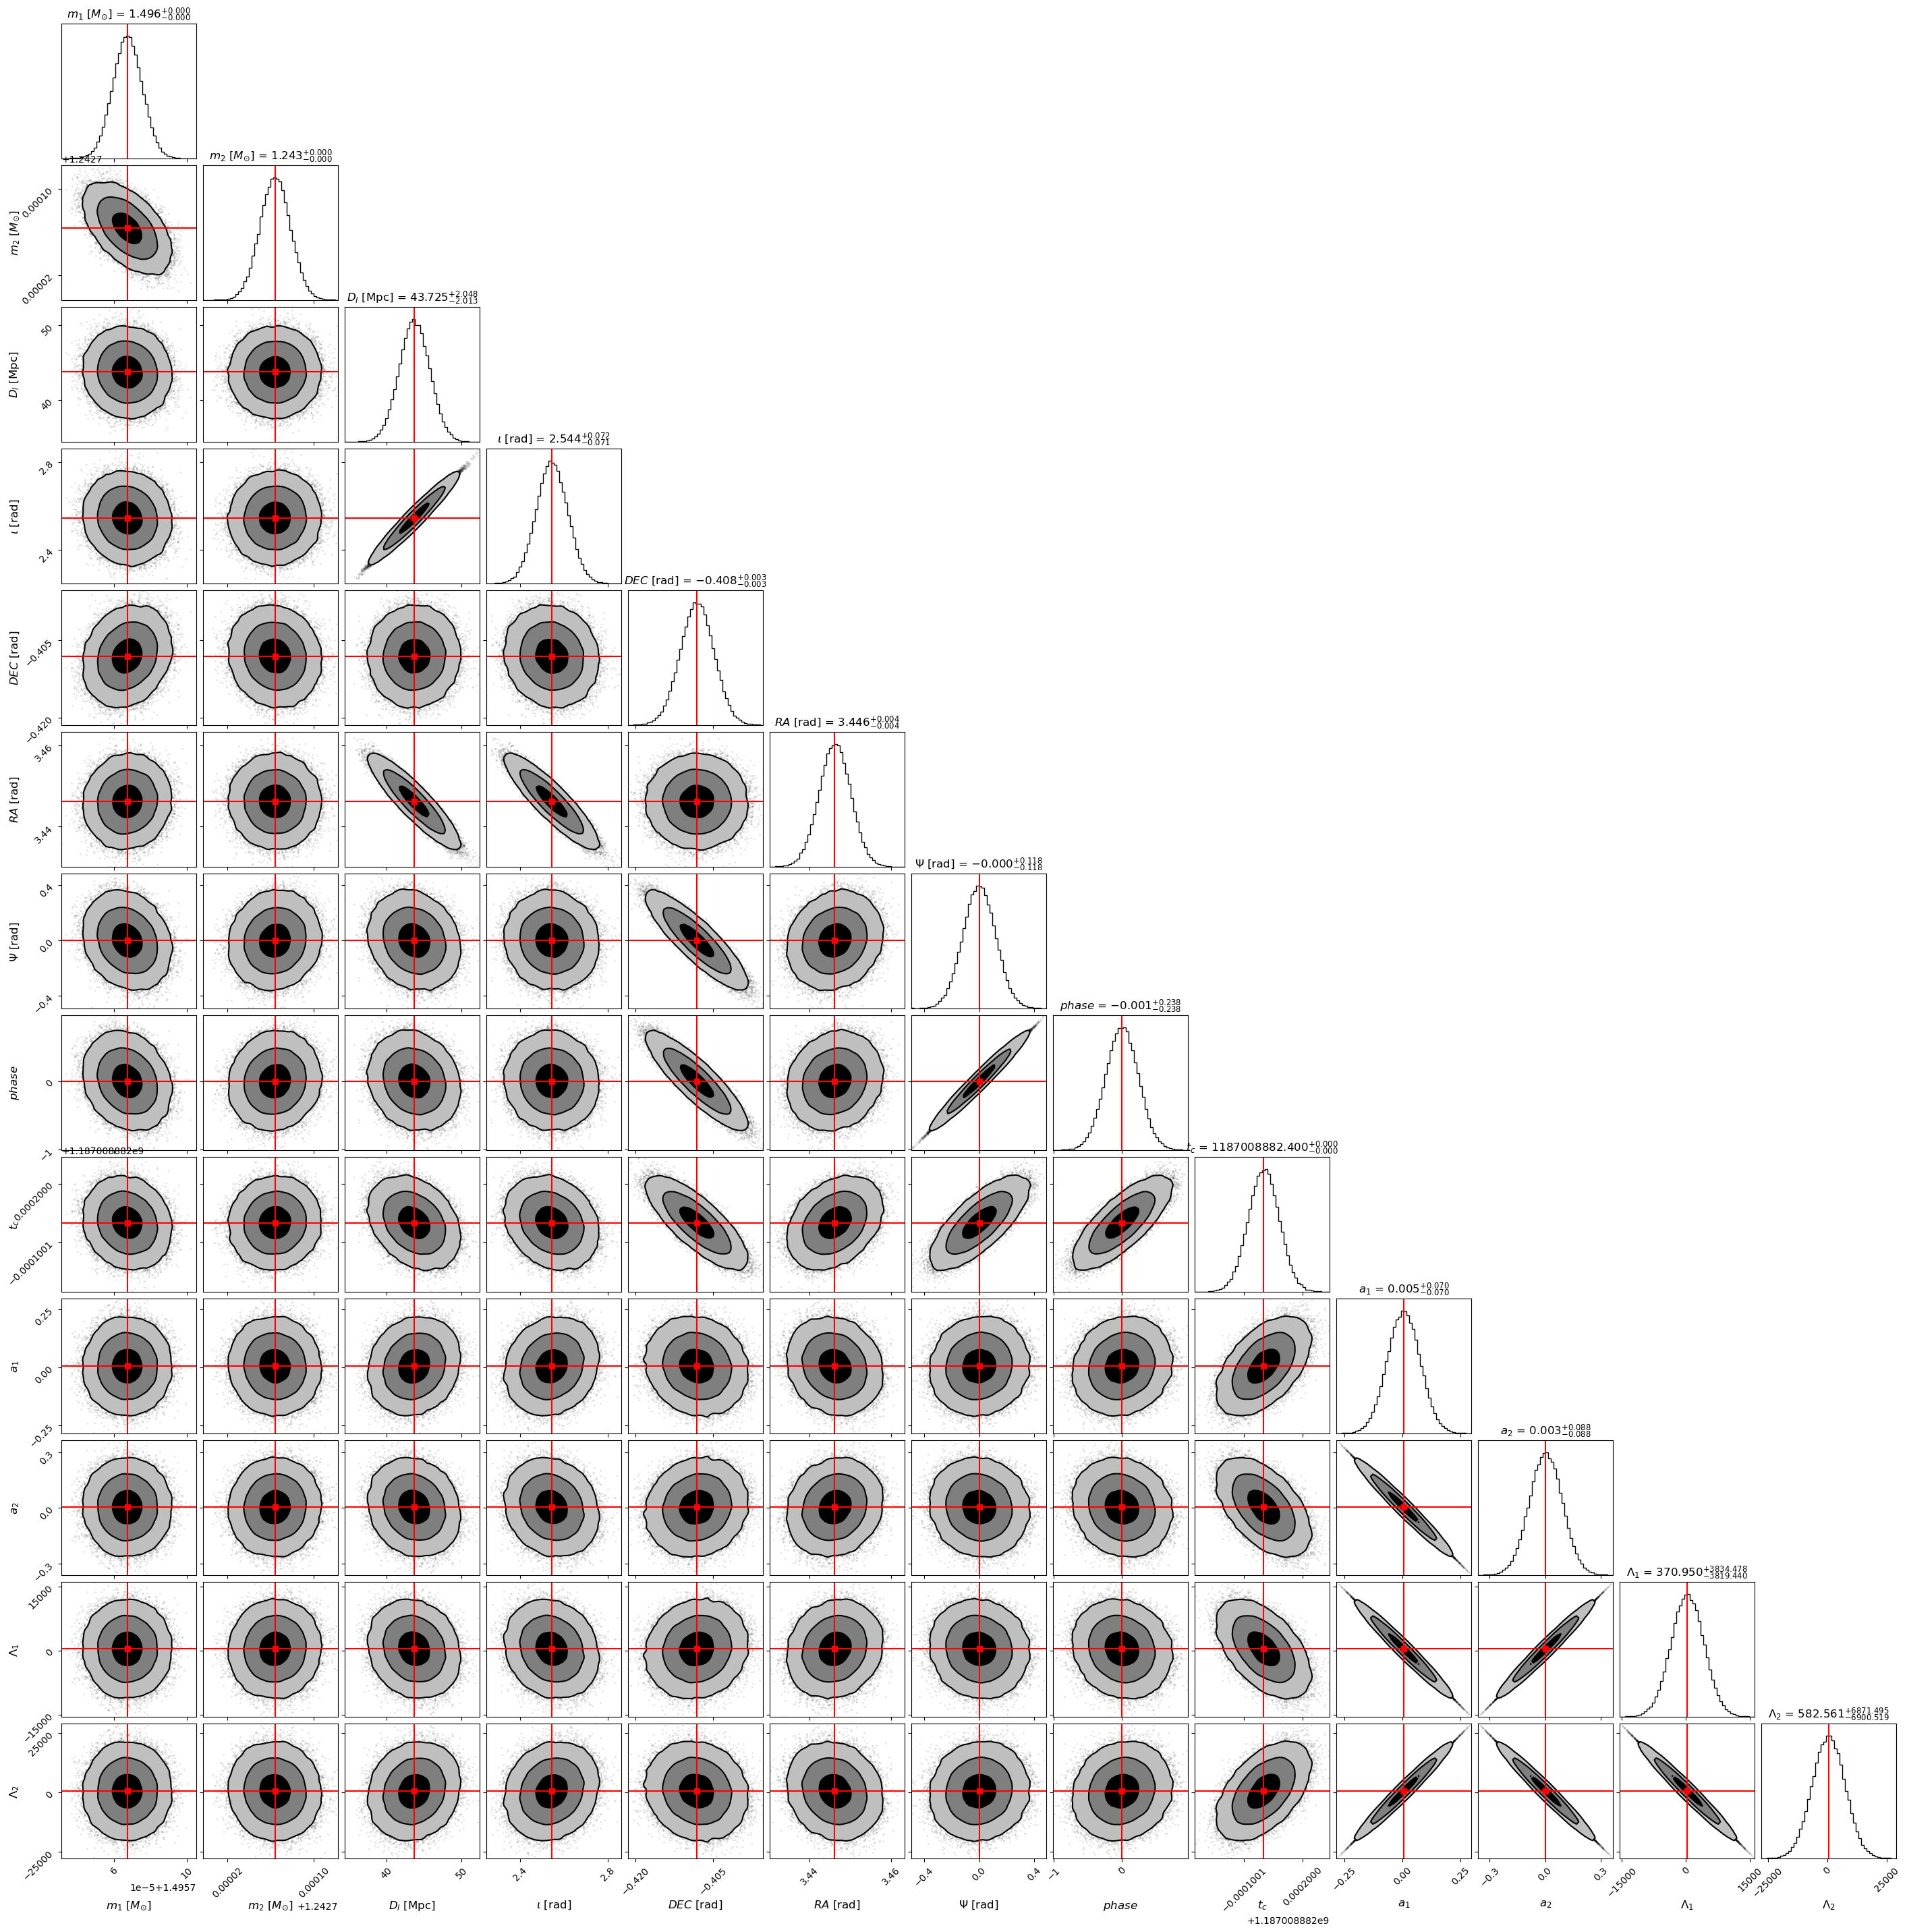

In [10]:
CORNER_KWARGS = dict(
    bins = 50, # number of bins for histograms
    smooth = 0.99, # smooths out contours. 
    plot_datapoints = True, # choose if you want datapoints
    label_kwargs = dict(fontsize = 12), # font size for labels
    show_titles = True, #choose if you want titles on top of densities.
    title_kwargs = dict(fontsize = 12), # font size for title
    plot_density = False,
    title_quantiles = [0.16, 0.5, 0.84],  # add quantiles to plot densities for 1d hist
    levels = (1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), # 1, 2 and 3 sigma contours for 2d plots
    fill_contours = True, #decide if you want to fill the contours
    max_n_ticks = 2, # set a limit to ticks in the x-y axes.
    title_fmt=".3f"
    )
corner_lbs = [r'$m_1$ $[M_{\odot}]$', '$m_2$ $[M_{\odot}]$', '$D_l$ [Mpc]',
                '$\iota$ [rad]', '$DEC$ [rad]', '$RA$ [rad]', '$\Psi$ [rad]',
                 '$phase$', '$t_c$', '$a_1$', '$a_2$', '$\Lambda_1$', '$\Lambda_2$']
mean_values = [parameters['mass_1'].iloc[0], parameters['mass_2'].iloc[0], 
               parameters['luminosity_distance'].iloc[0],
               parameters['theta_jn'].iloc[0], parameters['dec'].iloc[0], 
               parameters['ra'].iloc[0], parameters['psi'].iloc[0],
               parameters['phase'].iloc[0], parameters['geocent_time'].iloc[0],
               parameters['a_1'].iloc[0], parameters['a_2'].iloc[0],
               parameters['lambda_1'].iloc[0], parameters['lambda_2'].iloc[0]]

# Sample from a multi-variate gaussian with the given covariance matrix and injected mean values
samples = np.random.multivariate_normal(mean_values, cov_matrix, int(1e5))
fig = corner.corner(samples, labels = corner_lbs, truths = mean_values, truth_color = 'red',
                    **CORNER_KWARGS)
plt.show()

# BNS (or BBH) Population Analysis

* The `threshold_SNR` specifies in the first entry what is the minimum SNR for a detector to be included in the network, while the second entry is the lower threshold for the network SNR so that the Fisher matrix of the event is calculated
* If we want to calculate the uncertainties on the injected parameters values we need to specify `calculate_errors = True` and list the parameters to include in the Fisher analysis `fisher_parameters = ['...']`
* For a more realistic analysis we can include the duty cycle of the detectors using `duty_cycle = True`

In [11]:
population = 'BNS' # or 'BBH'
detectors = ['ET']
networks = '[[0]]'

detectors_ids = detectors
networks_ids = json.loads(networks)
ConfigDet = os.path.join(GWFish_path,'detectors.yaml')

waveform_model = 'TaylorF2'
waveform_class = gw.waveforms.LALFD_Waveform
threshold_SNR = np.array([0., 12.])
calculate_errors = True
duty_cycle = True
np.random.seed(0)

###### Fisher parameters ######
### for BNSs ###
fisher_parameters = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
                     'psi', 'geocent_time', 'phase', 'lambda_1', 'lambda_2']
### for BBHs ###
#fisher_parameters = ['mass_1', 'mass_2', 'luminosity_distance', 'theta_jn', 'dec','ra',
#                     'psi', 'geocent_time']

In [12]:
data_path = 'injections/%s_pop_test.hdf5' %str(population)

pop_parameters = pd.read_hdf(data_path)

network = gw.detection.Network(detectors_ids, detection_SNR=threshold_SNR, parameters=pop_parameters,
                                   fisher_parameters=fisher_parameters, config=ConfigDet)
pop_parameters

,mass_1,mass_2,luminosity_distance,dec,ra,theta_jn,psi,geocent_time,phase,redshift,lambda_1,lambda_2
0,1.391732,1.412179,39.029320,-0.867,4.642,1.115,5.687,1.690911e+09,3.373,0.00875,281.840172,256.890116
1,1.502225,1.101705,6.876000,0.456,0.240,2.871,2.388,1.881983e+09,5.564,0.00155,164.293313,1070.004088
2,1.380773,1.458766,126.007492,0.749,2.009,1.721,4.734,1.720514e+09,2.386,0.02785,332.827359,235.679582
3,1.425841,1.229951,131.552855,-0.702,2.506,1.704,1.046,1.689520e+09,2.655,0.02905,274.541019,667.631358
4,1.335319,1.477039,128.778989,-0.043,5.311,2.094,4.792,1.645462e+09,0.056,0.02845,409.291931,218.500863
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.365994,1.510687,315.885857,0.203,0.887,2.577,2.918,1.673145e+09,5.892,0.06785,447.641548,240.666201
96,1.445858,1.552432,321.740117,1.042,0.892,1.826,4.982,1.662364e+09,2.534,0.06905,318.850899,203.282003
97,1.511638,1.476152,359.026739,0.143,0.579,1.953,3.909,1.862603e+09,2.848,0.07665,252.396838,293.136146
98,1.470811,1.382901,321.251916,0.446,2.176,0.660,4.599,1.801580e+09,4.393,0.06895,286.419067,418.649397


In [13]:
for k in tqdm(np.arange(len(pop_parameters))):
    parameter_values = pop_parameters.iloc[k]

    networkSNR_sq = 0
    for d in np.arange(len(network.detectors)):
        data_params = {
            'frequencyvector': network.detectors[d].frequencyvector,
            'f_ref': 50.
        }
        waveform_obj = waveform_class(waveform_model, parameter_values, data_params)
        wave = waveform_obj()
        t_of_f = waveform_obj.t_of_f

        signal = gw.detection.projection(parameter_values, network.detectors[d], wave, t_of_f)

        SNRs = gw.detection.SNR(network.detectors[d], signal, duty_cycle=duty_cycle)
        networkSNR_sq += np.sum(SNRs ** 2)
        network.detectors[d].SNR[k] = np.sqrt(np.sum(SNRs ** 2))

        if calculate_errors:
            network.detectors[d].fisher_matrix[k, :, :] = \
                gw.fishermatrix.FisherMatrix(waveform_model, parameter_values, fisher_parameters, network.detectors[d], waveform_class=waveform_class).fm

    network.SNR[k] = np.sqrt(networkSNR_sq)

gw.detection.analyzeDetections(network, pop_parameters, population, networks_ids)

if calculate_errors:
    gw.fishermatrix.analyzeFisherErrors(network, pop_parameters, fisher_parameters, population, networks_ids)

100%|███████████████████████████████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29it/s]

Network: ET
Detected signals with SNR>12.000: 0.990 (99 out of 100); z<0.077
SNR: 0.000 (min) , 8240.080 (max) 


In [14]:
errors = pd.read_csv('Errors_ET_%s_SNR%s.txt' %(population, threshold_SNR[1]), delimiter = ' ')
print(errors.keys())

Index(['network_SNR', 'mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra',
       'theta_jn', 'psi', 'geocent_time', 'phase', 'redshift', 'lambda_1',
       'lambda_2', 'err_mass_1', 'err_mass_2', 'err_luminosity_distance',
       'err_theta_jn', 'err_dec', 'err_ra', 'err_psi', 'err_geocent_time',
       'err_phase', 'err_lambda_1', 'err_lambda_2', 'err_sky_location'],
      dtype='object')


## Plots of injected data

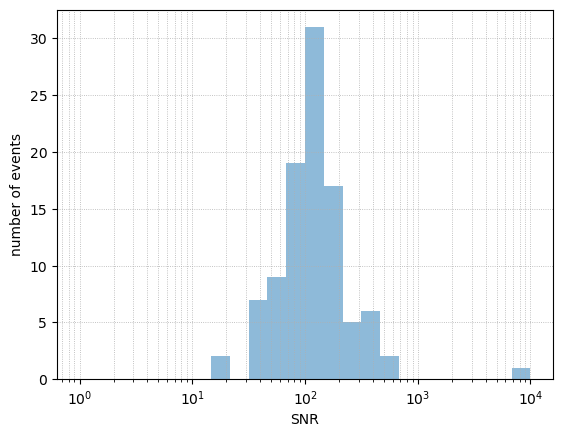

In [15]:
plt.hist(errors['network_SNR'], bins = np.logspace(0,4,25), alpha = 0.5)
plt.xlabel('SNR')
plt.xscale('log')
plt.ylabel('number of events')
plt.grid(linestyle='dotted', linewidth='0.6', which='both')

plt.show()

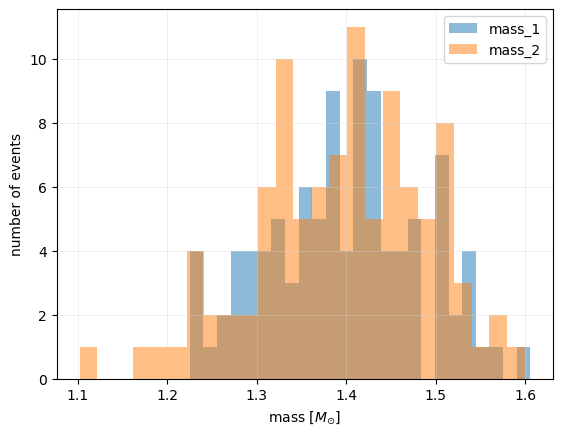

In [16]:
plt.hist(errors['mass_1'], bins = 25, label = 'mass_1', alpha= 0.5)
plt.hist(errors['mass_2'], bins = 25, label = 'mass_2', alpha= 0.5)
plt.legend()
plt.xlabel('mass [$M_{\odot}$]')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

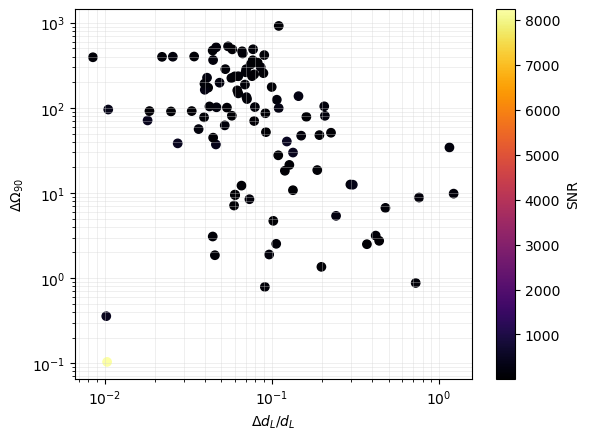

In [17]:
# Cut the results to max sky_loc = whole_sky
whole_sky = 4 * np.pi
errors = errors.loc[errors['err_sky_location'] <= whole_sky]

sky_loc_conv = 4.6 * (180. / np.pi)**2
sc = plt.scatter(errors['err_luminosity_distance']/errors['luminosity_distance'],
                 sky_loc_conv * errors['err_sky_location'],
                 c = errors['network_SNR'], cmap = 'inferno')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('$\Delta \Omega_{90}$')
plt.colorbar(sc, label = 'SNR')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

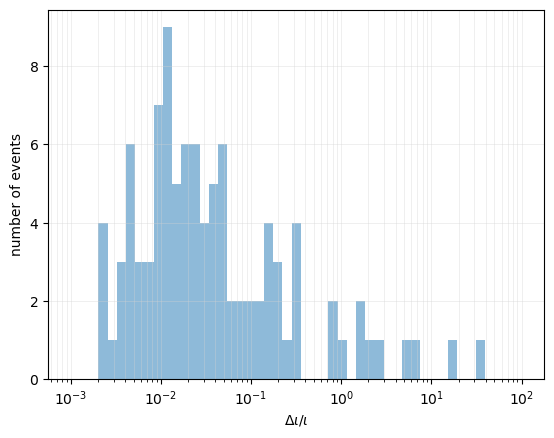

In [18]:
plt.hist(errors['err_theta_jn']/errors['theta_jn'], bins = np.logspace(-3, 2, 50), alpha = 0.5)
plt.xscale('log')
plt.xlabel('$\Delta \iota/\iota$')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()

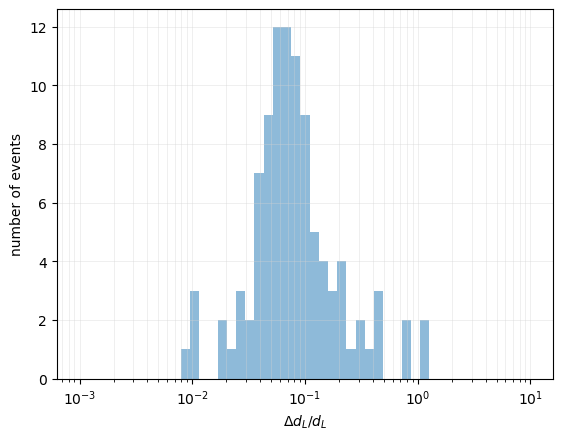

In [19]:
plt.hist(errors['err_luminosity_distance']/errors['luminosity_distance'], bins = np.logspace(-3, 1, 50), alpha = 0.5)
plt.xscale('log')
plt.xlabel('$\Delta d_L/d_L$')
plt.ylabel('number of events')
plt.grid(which = 'both', color = 'lightgray', alpha = 0.5, linewidth = 0.5)
plt.show()